In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import re

In [33]:
def clean(df, topk=False):
    df = df[df['State'] == 'finished']

    if topk:
        patterns = ['effective_l0$', 'frac_recovered$', 'mse_loss$', 'loss_original$', 'loss_reconstructed']
    else:
        patterns = ['l0$', 'frac_recovered$', 'mse_loss$', 'loss_original$', 'loss_reconstructed']
    filtered_columns = df.columns[df.columns.str.contains('|'.join(patterns))]
    df = df[filtered_columns]
    df.columns = [col.split('/')[-1] for col in df.columns]
    df = df.dropna(axis=1, how='any')
    
    if topk:
        l0 = df["effective_l0"].to_numpy().flatten()
    else:
        l0 = df["l0"].to_numpy().flatten()
    mse_loss = df["mse_loss"].to_numpy().flatten()
    frac_recovered = df["frac_recovered"].to_numpy().flatten()
    loss_original = df["loss_original"].to_numpy().flatten()
    loss_reconstructed = df["loss_reconstructed"].to_numpy().flatten()
    delta_ce = loss_reconstructed - loss_original

    data = np.array([l0, mse_loss, frac_recovered, delta_ce]).T
    df = pd.DataFrame(data, columns=['l0', 'mse_loss', 'frac_recovered', 'delta_ce'])
    df = df.sort_values(by='l0')
    return df

In [34]:
def clean_switch(df):
    df = df[df['State'] == 'finished']

    patterns = ['experts$', 'effective_l0$', 'mse_loss$', 'frac_recovered$', 'loss_original$', 'loss_reconstructed$', 'frac_recovered$']
    filtered_columns = df.columns[df.columns.str.contains('|'.join(patterns))]
    df = df[filtered_columns]
    df.columns = [re.split(r'[./]', col)[-1] for col in df.columns]
    
    l0 = df["effective_l0"].to_numpy().flatten()
    mse_loss = df["mse_loss"].to_numpy().flatten()
    experts = df["experts"].to_numpy().flatten()
    loss_original = df["loss_original"].to_numpy().flatten()
    loss_reconstructed = df["loss_reconstructed"].to_numpy().flatten()
    frac_recovered = df["frac_recovered"].to_numpy().flatten()
    delta_ce = loss_reconstructed - loss_original

    data = np.array([experts, l0, mse_loss, frac_recovered, delta_ce]).T
    df = pd.DataFrame(data, columns=['experts', 'l0', 'mse_loss', 'frac_recovered', 'delta_ce'])
    df = df.sort_values(by='l0')
    return df

In [35]:
df_relu = pd.read_csv("primary-relu.csv")
df_relu = clean(df_relu)

df_gated = pd.read_csv("primary-gated.csv")
df_gated = clean(df_gated)

df_topk = pd.read_csv("primary-topk.csv")
df_topk = clean(df_topk, topk=True)

In [36]:
df_relu.to_csv("primary-relu-clean.csv")
df_gated.to_csv("primary-gated-clean.csv")
df_topk.to_csv("primary-topk-clean.csv")

In [37]:
df_relu = pd.read_csv("primary-relu-clean.csv")
df_gated = pd.read_csv("primary-gated-clean.csv")
df_topk = pd.read_csv("primary-topk-clean.csv")

In [38]:
df_switch8 = pd.read_csv('primary-switch8e.csv')
df_switch8 = clean(df_switch8, topk=True)

In [39]:
df_switch_flop = pd.read_csv('primary-switch-flop.csv')
df_switch_flop = clean_switch(df_switch_flop)

In [40]:
df_switch_flop

,experts,l0,mse_loss,frac_recovered,delta_ce
6,2.0,8.0,2125.846191,0.966782,0.466185
12,4.0,8.0,2074.264648,0.968456,0.442698
7,2.0,16.0,1455.818481,0.986436,0.193990
13,4.0,16.0,1379.365479,0.986589,0.192181
3,2.0,32.0,1031.368164,0.992392,0.106771
14,4.0,32.0,959.533691,0.993373,0.095398
4,2.0,64.0,805.609680,0.996076,0.056119
9,4.0,64.0,750.890320,0.995814,0.058753
0,2.0,128.0,605.957275,0.997035,0.041612
10,4.0,128.0,560.694824,0.997503,0.035780


In [41]:
df_switch_flop2 = df_switch_flop[df_switch_flop['experts'] == 2]
df_switch_flop4 = df_switch_flop[df_switch_flop['experts'] == 4]
#df_switch_flop8 = df_switch_flop[df_switch_flop['experts'] == 8]

## Plotting

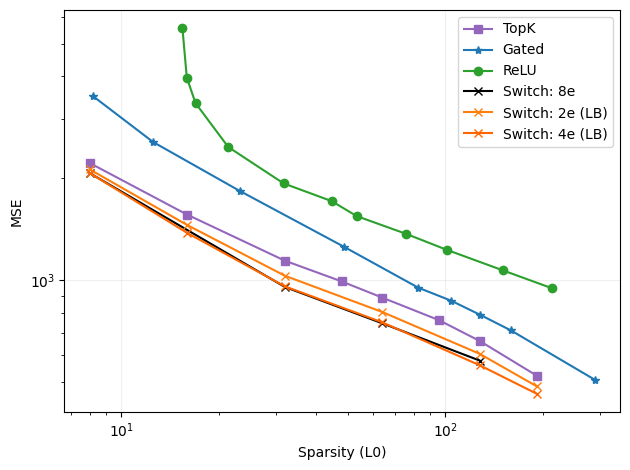

In [42]:
plt.plot(df_topk['l0'], df_topk['mse_loss'], label='TopK', marker='s', color='#9467bd')
plt.plot(df_gated['l0'], df_gated['mse_loss'], label='Gated', marker='*', color='#1f77b4')
plt.plot(df_relu['l0'], df_relu['mse_loss'], label='ReLU', marker='o', color='#2ca02c')

plt.plot(df_switch8['l0'], df_switch8['mse_loss'], label='Switch: 8e', marker='x', color='#000000')
plt.plot(df_switch_flop2['l0'], df_switch_flop2['mse_loss'], label='Switch: 2e (LB)', marker='x', color='#ff7f0e')
plt.plot(df_switch_flop4['l0'], df_switch_flop4['mse_loss'], label='Switch: 4e (LB)', marker='x', color='#ff6600')
#plt.plot(df_switch_flop8['l0'], df_switch_flop8['mse_loss'], label='Switch: 8e (LB)', marker='x', color='#ff4d00')

plt.xscale('log')
plt.yscale('log')

plt.xlabel("Sparsity (L0)")
plt.ylabel("MSE")

plt.legend()

plt.grid(True, which="major", ls="-", alpha=0.2)


plt.tight_layout()
plt.savefig("flopmatch_l0_mse.png")
plt.show()

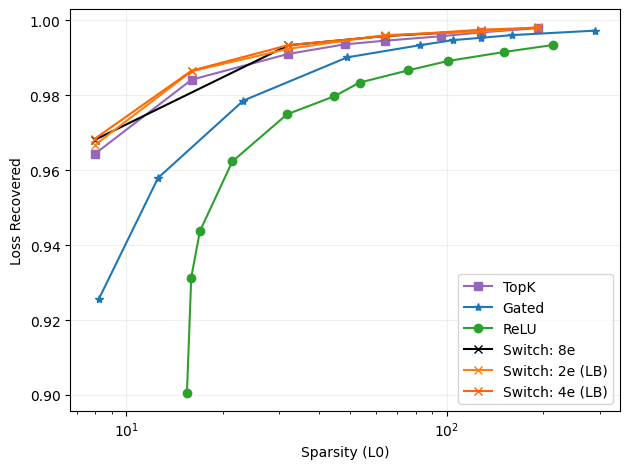

In [45]:
plt.plot(df_topk['l0'], df_topk['frac_recovered'], label='TopK', marker='s', color='#9467bd')
plt.plot(df_gated['l0'], df_gated['frac_recovered'], label='Gated', marker='*', color='#1f77b4')
plt.plot(df_relu['l0'], df_relu['frac_recovered'], label='ReLU', marker='o', color='#2ca02c')

plt.plot(df_switch8['l0'], df_switch8['frac_recovered'], label='Switch: 8e', marker='x', color='#000000')
plt.plot(df_switch_flop2['l0'], df_switch_flop2['frac_recovered'], label='Switch: 2e (LB)', marker='x', color='#ff7f0e')
plt.plot(df_switch_flop4['l0'], df_switch_flop4['frac_recovered'], label='Switch: 4e (LB)', marker='x', color='#ff6600')
#plt.plot(df_switch_flop8['l0'], df_switch_flop8['frac_recovered'], label='Switch: 8e (LB)', marker='x', color='#ff4d00')

plt.xscale('log')
#plt.yscale('log')

plt.xlabel("Sparsity (L0)")
plt.ylabel("Loss Recovered")

plt.legend()

plt.grid(True, which="major", ls="-", alpha=0.2)


plt.tight_layout()
plt.savefig("flopmatch_l0_lossrec.png")
plt.show()

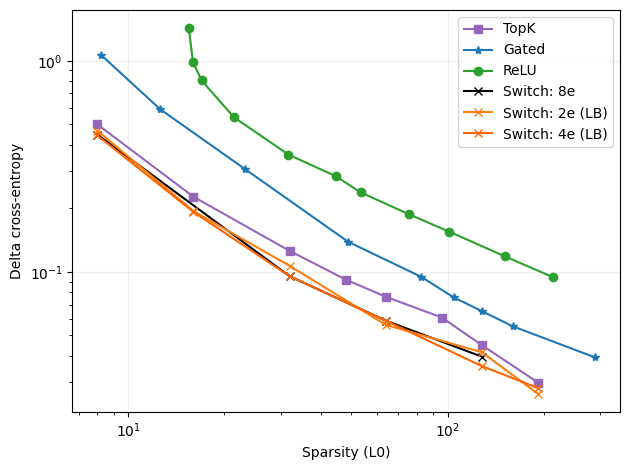

In [46]:
plt.plot(df_topk['l0'], df_topk['delta_ce'], label='TopK', marker='s', color='#9467bd')
plt.plot(df_gated['l0'], df_gated['delta_ce'], label='Gated', marker='*', color='#1f77b4')
plt.plot(df_relu['l0'], df_relu['delta_ce'], label='ReLU', marker='o', color='#2ca02c')

plt.plot(df_switch8['l0'], df_switch8['delta_ce'], label='Switch: 8e', marker='x', color='#000000')
plt.plot(df_switch_flop2['l0'], df_switch_flop2['delta_ce'], label='Switch: 2e (LB)', marker='x', color='#ff7f0e')
plt.plot(df_switch_flop4['l0'], df_switch_flop4['delta_ce'], label='Switch: 4e (LB)', marker='x', color='#ff6600')
#plt.plot(df_switch_flop8['l0'], df_switch_flop8['delta_ce'], label='Switch: 8e (LB)', marker='x', color='#ff4d00')


plt.xscale('log')
plt.yscale('log')

plt.xlabel("Sparsity (L0)")
plt.ylabel("Delta cross-entropy")

plt.legend()

plt.grid(True, which="major", ls="-", alpha=0.2)


plt.tight_layout()
plt.savefig("flopmatch_l0_deltace.png")
plt.show()

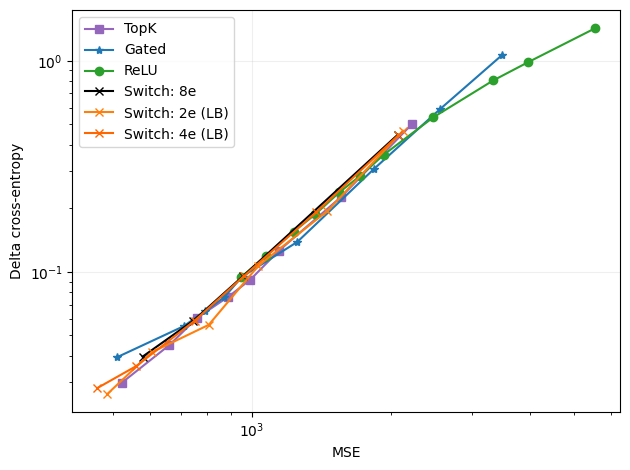

In [47]:
plt.plot(df_topk['mse_loss'], df_topk['delta_ce'], label='TopK', marker='s', color='#9467bd')
plt.plot(df_gated['mse_loss'], df_gated['delta_ce'], label='Gated', marker='*', color='#1f77b4')
plt.plot(df_relu['mse_loss'], df_relu['delta_ce'], label='ReLU', marker='o', color='#2ca02c')

plt.plot(df_switch8['mse_loss'], df_switch8['delta_ce'], label='Switch: 8e', marker='x', color='#000000')
plt.plot(df_switch_flop2['mse_loss'], df_switch_flop2['delta_ce'], label='Switch: 2e (LB)', marker='x', color='#ff7f0e')
plt.plot(df_switch_flop4['mse_loss'], df_switch_flop4['delta_ce'], label='Switch: 4e (LB)', marker='x', color='#ff6600')
#plt.plot(df_switch_flop8['l0'], df_switch_flop8['delta_ce'], label='Switch: 8e (LB)', marker='x', color='#ff4d00')


plt.xscale('log')
plt.yscale('log')

plt.xlabel("MSE")
plt.ylabel("Delta cross-entropy")

plt.legend()

plt.grid(True, which="major", ls="-", alpha=0.2)


plt.tight_layout()
plt.savefig("flopmatch_mse_deltace.png")
plt.show()